In [78]:
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from sklearn.metrics import accuracy_score,hamming_loss
from keras.layers.merge import Concatenate
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [63]:
malignant_comments = pd.read_csv("Malignant_train_data.csv")

In [64]:
malignant_comments.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Checking for Missing Values

In [65]:
malignant_comments.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

There is no null values in the dataset.

In [66]:
malignant_comments.dtypes

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

All the values in the dataset are object or int type.

In [67]:
malignant_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## EDA Analysis

### Checking values of multilabels !=0 or 1

In [68]:
print(malignant_comments.loc[(malignant_comments.malignant!=0)&(malignant_comments.malignant!=1)].shape[0])
print(malignant_comments.loc[(malignant_comments.highly_malignant!=0)&(malignant_comments.highly_malignant!=1)].shape[0])
print(malignant_comments.loc[(malignant_comments.rude!=0)&(malignant_comments.rude!=1)].shape[0])
print(malignant_comments.loc[(malignant_comments.threat!=0)&(malignant_comments.threat!=1)].shape[0])
print(malignant_comments.loc[(malignant_comments.abuse!=0)&(malignant_comments.abuse!=1)].shape[0])
print(malignant_comments.loc[(malignant_comments.loathe!=0)&(malignant_comments.loathe!=1)].shape[0])

0
0
0
0
0
0


No values in multilabels are other than 0 or 1

### Removing all records where any row contain a null or empty string

In [69]:
filter = malignant_comments["comment_text"] != ""
malignant_comments = malignant_comments[filter]
malignant_comments = malignant_comments.dropna()

In [70]:
print(malignant_comments["comment_text"][111])

"

Comment. I could not verify the claim.  (talk) "


In [71]:
print("malignant:" + str(malignant_comments["malignant"][111]))
print("highly_malignant:" + str(malignant_comments["highly_malignant"][111]))
print("rude:" + str(malignant_comments["rude"][111]))
print("Threat:" + str(malignant_comments["threat"][111]))
print("abuse:" + str(malignant_comments["abuse"][111]))
print("loathe:" + str(malignant_comments["loathe"][111]))

malignant:0
highly_malignant:0
rude:0
Threat:0
abuse:0
loathe:0


### Checking for 0 values in each label

In [72]:
print(malignant_comments.loc[malignant_comments.malignant==0].shape[0])
print(malignant_comments.loc[malignant_comments.highly_malignant==0].shape[0])
print(malignant_comments.loc[malignant_comments.rude==0].shape[0])
print(malignant_comments.loc[malignant_comments.threat==0].shape[0])
print(malignant_comments.loc[malignant_comments.abuse==0].shape[0])
print(malignant_comments.loc[malignant_comments.loathe==0].shape[0])

144277
157976
151122
159093
151694
158166


### Checking for 1 values in each label

In [73]:
print(malignant_comments.loc[malignant_comments.malignant==1].shape[0])
print(malignant_comments.loc[malignant_comments.highly_malignant==1].shape[0])
print(malignant_comments.loc[malignant_comments.rude==1].shape[0])
print(malignant_comments.loc[malignant_comments.threat==1].shape[0])
print(malignant_comments.loc[malignant_comments.abuse==1].shape[0])
print(malignant_comments.loc[malignant_comments.loathe==1].shape[0])

15294
1595
8449
478
7877
1405


### Visualizing the Commnets with multiple labels

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


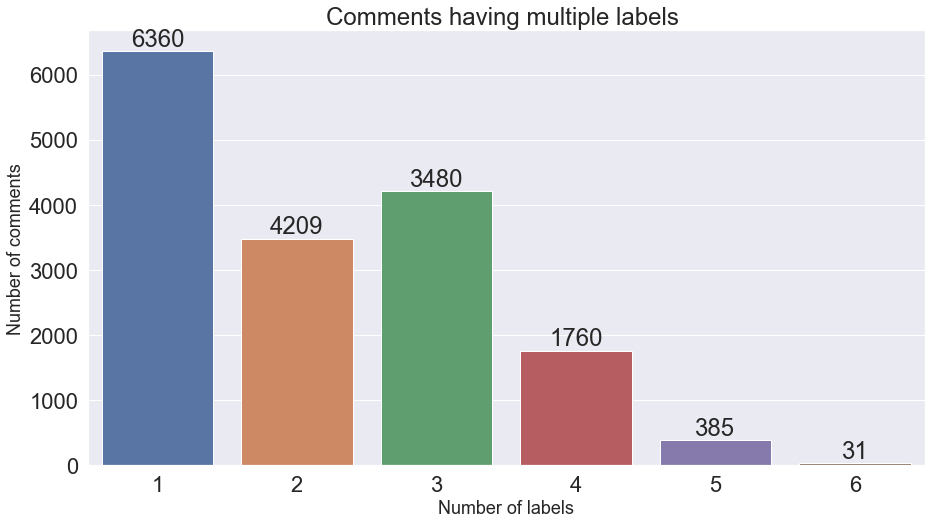

In [74]:
rowSums = malignant_comments.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [75]:
malignant_comments_labels = malignant_comments[["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]]
malignant_comments_labels.head()

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


### WordCloud

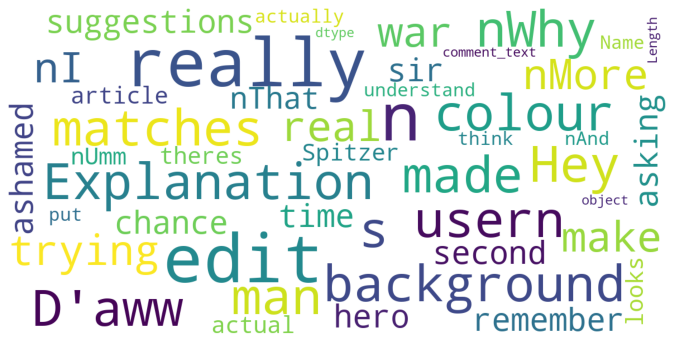

In [76]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(malignant_comments['comment_text'])

### Text_Preprocessing

In [79]:
stopwords_ = stopwords.words('english')

In [80]:
from nltk.stem import WordNetLemmatizer

In [81]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub('<.*?>','',text)
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub('\[|\(.*\]|\)','', text) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)  
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords_)]
    text = ' '.join(text)
    return text

In [82]:
malignant_comments['comment_text'] = malignant_comments['comment_text'].apply(preprocess_text)
malignant_comments['comment_text'][:10]

0    explanation edits made username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
5               congratulation well use tool well talk
6                          cocksucker piss around work
7    vandalism matt shirvington article reverted pl...
8    sorry word nonsense offensive anyway intending...
9                 alignment subject contrary dulithgow
Name: comment_text, dtype: object

In [83]:
X = malignant_comments['comment_text']
y = malignant_comments_labels.values

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [85]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [86]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Binary Relevance
This is the simplest technique, which basically treats each label as separate single class classification problem.In multi-label classification problem, we can't simply use our normal metrics to calculate the accuracy of our predictions. For that purpose we will use accuracy_score metric. This function calculates the subset of accuracy meaning the predicted set of labels should exactly match with the true set of labels.

In [89]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn import metrics
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
binarel = BinaryRelevance(GaussianNB())
# train
binarel.fit(X_train, y_train)
predictions = binarel.predict(X_test)
print(accuracy_score(y_test,predictions))
print(hamming_loss(y_test, predictions))
print(multilabel_confusion_matrix(y_test, predictions))
label_names = ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]
print(classification_report(y_test, predictions,target_names=label_names))

0.1587968040106533
0.38769126325134473
[[[ 6207 22652]
  [  377  2679]]

 [[30319  1275]
  [  302    19]]

 [[ 6747 23453]
  [  217  1498]]

 [[31453   388]
  [   74     0]]

 [[ 5815 24486]
  [  154  1460]]

 [[31047   574]
  [  287     7]]]
                  precision    recall  f1-score   support

       malignant       0.11      0.88      0.19      3056
highly_malignant       0.01      0.06      0.02       321
            rude       0.06      0.87      0.11      1715
          threat       0.00      0.00      0.00        74
           abuse       0.06      0.90      0.11      1614
          loathe       0.01      0.02      0.02       294

       micro avg       0.07      0.80      0.13      7074
       macro avg       0.04      0.46      0.07      7074
    weighted avg       0.07      0.80      0.13      7074
     samples avg       0.06      0.08      0.07      7074



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In the Classifier Chains the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.This is quite similar to binary relevance, the only difference being it forms chains in order to preserve label correlation.  

In [91]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classchain = ClassifierChain(GaussianNB())
# train
classchain.fit(X_train, y_train)
# predict
predictions = classchain.predict(X_test)
print(accuracy_score(y_test,predictions))
print(hamming_loss(y_test, predictions))
print(multilabel_confusion_matrix(y_test, predictions))
label_names = ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]
print(classification_report(y_test, predictions,target_names=label_names))

0.17330408898637004
0.6297195676014413
[[[ 6207 22652]
  [  377  2679]]

 [[30911   683]
  [  310    11]]

 [[ 6083 24117]
  [  195  1520]]

 [[ 9438 22403]
  [    8    66]]

 [[ 6293 24008]
  [  174  1440]]

 [[ 6001 25620]
  [   38   256]]]
                  precision    recall  f1-score   support

       malignant       0.11      0.88      0.19      3056
highly_malignant       0.02      0.03      0.02       321
            rude       0.06      0.89      0.11      1715
          threat       0.00      0.89      0.01        74
           abuse       0.06      0.89      0.11      1614
          loathe       0.01      0.87      0.02       294

       micro avg       0.05      0.84      0.09      7074
       macro avg       0.04      0.74      0.08      7074
    weighted avg       0.07      0.84      0.13      7074
     samples avg       0.04      0.09      0.05      7074



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In this, we transform the problem into a multi-class problem with one multi-class classifier is trained on all unique label combinations found in the training data.So, label powerset has given a unique class to every possible label combination that is present in the training set.

In [92]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
labelpst = LabelPowerset(GaussianNB())
# train
labelpst.fit(X_train, y_train)
# predict
predictions = labelpst.predict(X_test)
print(accuracy_score(y_test,predictions))
print(hamming_loss(y_test, predictions))
print(multilabel_confusion_matrix(y_test, predictions))
label_names = ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]
print(classification_report(y_test, predictions,target_names=label_names))

0.0007833307222309259
0.4676745521959371
[[[11603 17256]
  [  794  2262]]

 [[30133  1461]
  [  300    21]]

 [[20095 10105]
  [ 1334   381]]

 [[13889 17952]
  [   18    56]]

 [[10961 19340]
  [  719   895]]

 [[11472 20149]
  [  127   167]]]
                  precision    recall  f1-score   support

       malignant       0.12      0.74      0.20      3056
highly_malignant       0.01      0.07      0.02       321
            rude       0.04      0.22      0.06      1715
          threat       0.00      0.76      0.01        74
           abuse       0.04      0.55      0.08      1614
          loathe       0.01      0.57      0.02       294

       micro avg       0.04      0.53      0.08      7074
       macro avg       0.04      0.48      0.07      7074
    weighted avg       0.07      0.53      0.12      7074
     samples avg       0.04      0.06      0.04      7074



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
from sklearn.neural_network import MLPClassifier
mlpcf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
mlpcf.predict_proba(X_test)
predictions=mlpcf.predict(X_test)
mlpcf.score(X_test, y_test)
print(accuracy_score(y_test,predictions))
print(hamming_loss(y_test, predictions))
print(multilabel_confusion_matrix(y_test, predictions))
label_names = ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]
print(classification_report(y_test, predictions,target_names=label_names))

0.8981983393388688
0.03699932111337407
[[[28854     5]
  [ 3056     0]]

 [[31594     0]
  [  321     0]]

 [[30196     4]
  [ 1715     0]]

 [[31841     0]
  [   74     0]]

 [[30299     2]
  [ 1614     0]]

 [[31621     0]
  [  294     0]]]
                  precision    recall  f1-score   support

       malignant       0.00      0.00      0.00      3056
highly_malignant       0.00      0.00      0.00       321
            rude       0.00      0.00      0.00      1715
          threat       0.00      0.00      0.00        74
           abuse       0.00      0.00      0.00      1614
          loathe       0.00      0.00      0.00       294

       micro avg       0.00      0.00      0.00      7074
       macro avg       0.00      0.00      0.00      7074
    weighted avg       0.00      0.00      0.00      7074
     samples avg       0.00      0.00      0.00      7074



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
predictions=rf.predict(X_test)
print(accuracy_score(y_test,predictions))
print(hamming_loss(y_test, predictions))
print(multilabel_confusion_matrix(y_test, predictions))
label_names = ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"]
print(classification_report(y_test, predictions,target_names=label_names))

0.898355005483315
0.036941876860410464
[[[28859     0]
  [ 3056     0]]

 [[31594     0]
  [  321     0]]

 [[30200     0]
  [ 1715     0]]

 [[31841     0]
  [   74     0]]

 [[30301     0]
  [ 1614     0]]

 [[31621     0]
  [  294     0]]]
                  precision    recall  f1-score   support

       malignant       0.00      0.00      0.00      3056
highly_malignant       0.00      0.00      0.00       321
            rude       0.00      0.00      0.00      1715
          threat       0.00      0.00      0.00        74
           abuse       0.00      0.00      0.00      1614
          loathe       0.00      0.00      0.00       294

       micro avg       0.00      0.00      0.00      7074
       macro avg       0.00      0.00      0.00      7074
    weighted avg       0.00      0.00      0.00      7074
     samples avg       0.00      0.00      0.00      7074



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classif

### Cross-Validation-Score

In [95]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(binarel,X_train,y_train,cv=5)
print(score)
print(score.mean())
print(score.std())

[0.1700611  0.1227919  0.15600642 0.1348165  0.13238808]
0.14321279964670558
0.01725800497086918


In [96]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classchain,X_train,y_train,cv=5)
print(score)
print(score.mean())
print(score.std())

[0.18357355 0.16176413 0.17347538 0.17833222 0.17750969]
0.17493099703454817
0.0073266230649261235


In [97]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(labelpst,X_train,y_train,cv=5)
print(score)
print(score.mean())
print(score.std())

[0.00043083 0.00078336 0.00058752 0.00387764 0.00133171]
0.0014022135378019096
0.0012745968143604831


In [98]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(mlpcf,X_train,y_train,cv=5)
print(score)
print(score.mean())
print(score.std())

[0.89526868 0.89894638 0.89988641 0.89651796 0.89663546]
0.8974509790554037
0.0017009156267301499


In [99]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(rf,X_train,y_train,cv=5)
print(score)
print(score.mean())
print(score.std())

[0.89569951 0.89945556 0.90160981 0.89687047 0.89792801]
0.898312673224595
0.0020607671948085523


### DNN Model

In [100]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [101]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          13890800  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 14,008,822
Trainable params: 118,022
Non-trainable params: 13,890,800
_________________________________________________________________
None


In [102]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 600s 749ms/step - loss: 0.1471 - acc: 0.9696 - val_loss: 0.1415 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 533s 668ms/step - loss: 0.1373 - acc: 0.9939 - val_loss: 0.0982 - val_acc: 0.9943
Epoch 3/5
798/798 [==============================] - 532s 666ms/step - loss: 0.0766 - acc: 0.9941 - val_loss: 0.0642 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 531s 666ms/step - loss: 0.0601 - acc: 0.9942 - val_loss: 0.0585 - val_acc: 0.9942
Epoch 5/5
798/798 [==============================] - 591s 741ms/step - loss: 0.0560 - acc: 0.9940 - val_loss: 0.0570 - val_acc: 0.9942


In [103]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 108s 108ms/step - loss: 0.0563 - acc: 0.9940
Test Score: 0.05628538876771927
Test Accuracy: 0.993984043598175


In [104]:
score=model.evaluate(X_train,y_train, verbose=1)
print('Training Score:',score[0])
print("Training Accuracy:", score[1])

3990/3990 [==============================] - 381s 96ms/step - loss: 0.0542 - acc: 0.9941
Training Score: 0.05417363718152046
Training Accuracy: 0.9941248297691345


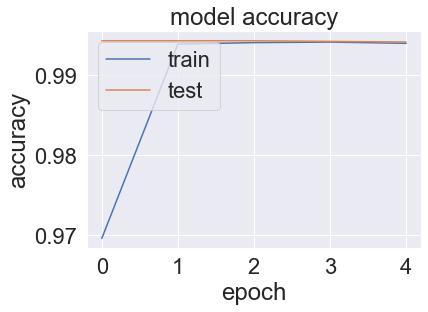

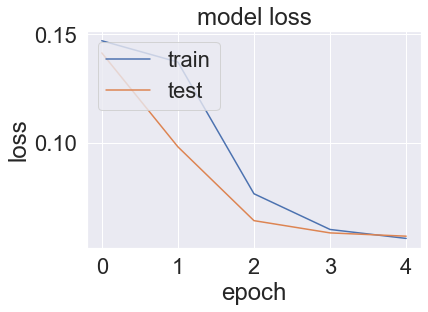

In [105]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

 Since our Deep Learning Model is performing best with highest accuracy we will go with our Deep Learning Model.

## Predicting the result

In [117]:
malignant_test=pd.read_csv("Malignant_test_data.csv")

### Preprocessing-Text

In [118]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub('<.*?>','',text)
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub('\[|\(.*\]|\)','', text) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)  
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords_)]
    text = ' '.join(text)
    return text

In [119]:
malignant_test['comment_text'] = malignant_test['comment_text'].apply(preprocess_text)
malignant_test['comment_text'][:10]

0    yo bitch ja rule succesful ever whats hating s...
1                                   rfc title fine imo
2                           source zawe ashton lapland
3    look back source information updated correct f...
4                             anonymously edit article
5    thank understanding think highly would revert ...
6    please add nonsense wikipedia edits considered...
7                               dear god site horrible
8    fool believe number correct number lie ponder ...
9    double redirects fixing double redirects blank...
Name: comment_text, dtype: object

In [120]:
X_test = malignant_test['comment_text']

In [121]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Predicting the Result

In [122]:
pred = model.predict(X_test)

In [134]:
Predicted=np.select([pred <= .5, pred>.5], [np.zeros_like(pred), np.ones_like(pred)])

In [138]:
Predicted = pd.DataFrame(Predicted, columns= ["malignant", "highly_malignant", "rude", "threat", "abuse", "loathe"])

In [140]:
Predicted=Predicted.astype(int)

In [142]:
Predicted.to_csv('Predicted_test')

### Saving the Model

In [1]:
import joblib
joblib.dump(model,"Malignant_Comment_Project_.pkl")

NameError: name 'model' is not defined